# Pytorchを用いた深層学習の基本


## Fashion MNISTデータセットのLoad

In [21]:
import torch
import torchvision
from torchvision import transforms

transformer = transforms.Compose([
    transforms.Resize(256), 
    transforms.CenterCrop(224), 
    transforms.ToTensor()
])

trainval_dataset = torchvision.datasets.FashionMNIST(
    '/home/akiyo/datasets', train=True, download=True, transform=transformer
)
test_dataset = torchvision.datasets.FashionMNIST(
    '/home/akiyo/datasets', train=False, download=True, transform=transformer
)

train_size = int(len(trainval_dataset) * 0.8)
val_size = int(len(trainval_dataset) - train_size)
train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [train_size, val_size])
print(len(train_dataset), len(val_dataset))
BATCH_SIZE = 128

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=8, shuffle=False, num_workers=2
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=8, shuffle=False, num_workers=2
)

#dataloader_length = dataset_length * BATCH_SIZE
print(len(train_dataloader), len(val_dataloader), len(test_dataloader))

48000 12000
375 1500 1250


## Build Your Own Custom Dataset

In [22]:
class GeneralDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir=None, masks_dir=None, image_extension=None, mask_extension=None, transformer=None):
        super(GeneralDataset, self).__init__()
        pass

    def __getitem__(self, index):
        pass

    def __len__(self):
        pass

dataset = GeneralDataset()
#dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

## データ仕様の確認

In [23]:
def show_fashion_mnist(images, labels):
    _, figs = plt.subplots(1, len(images), figsize=(28, 28))
    for f, img, lbl in zip(figs, images, labels):
        # np.squeeze let (1, 28, 28) to (28, 28)
        f.imshow(np.squeeze(img.numpy()), cmap="gray")
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

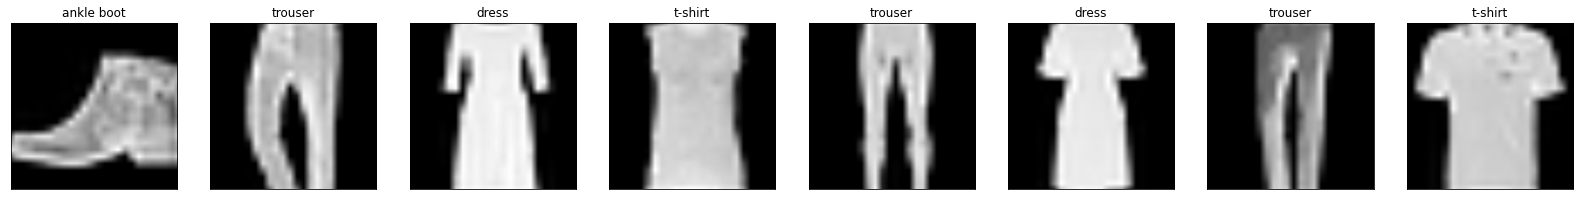

In [24]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
labels_name = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
images, labels = next(iter(val_dataloader))
labels = [labels_name[int(i)] for i in labels]
show_fashion_mnist(images, labels)

## Pytorch Modelを構築する

In [25]:
%%capture
!pip install torchinfo

In [26]:
#example for 
import torch
import torch.nn

In [27]:
class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.identity = torch.nn.Identity()

    def forward(self, x):
        result = self.identity(x)
        return result

ipt = torch.randn(1, 3, 128, 128)
net = Network()
opt = net(ipt)

print((ipt == opt))

tensor([[[[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]],

         [[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]],

         [[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ...

resnet18 source code: https://pytorch.org/vision/0.8/_modules/torchvision/models/resnet.html#resnet18

resnet18, 34, 50, 101, 152
![](https://pytorch.org/assets/images/resnet.png)

In [28]:
import torchvision.models as models
from torchinfo import summary

model = models.resnet18(pretrained=True)
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = torch.nn.Linear(in_features=512, out_features=len(labels_name), bias=True)
#print(model)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

summary(
    model,
    input_size=(BATCH_SIZE, 1, 224, 224),
    col_names=["output_size", "num_params"],
)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 10]                 --
├─Conv2d: 1-1                            [128, 64, 112, 112]       3,136
├─BatchNorm2d: 1-2                       [128, 64, 112, 112]       128
├─ReLU: 1-3                              [128, 64, 112, 112]       --
├─MaxPool2d: 1-4                         [128, 64, 56, 56]         --
├─Sequential: 1-5                        [128, 64, 56, 56]         --
│    └─BasicBlock: 2-1                   [128, 64, 56, 56]         --
│    │    └─Conv2d: 3-1                  [128, 64, 56, 56]         36,864
│    │    └─BatchNorm2d: 3-2             [128, 64, 56, 56]         128
│    │    └─ReLU: 3-3                    [128, 64, 56, 56]         --
│    │    └─Conv2d: 3-4                  [128, 64, 56, 56]         36,864
│    │    └─BatchNorm2d: 3-5             [128, 64, 56, 56]         128
│    │    └─ReLU: 3-6                    [128, 64, 56, 56]         --
│

## Loss, Optimization and Metrics function

PyTorchの `Optimizer` と `Scheduler` の挙動

`Optimizer` ミニバッチごとに学習率が変化する。 

In [29]:
criterion = torch.nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
metrics = lambda predictions, labels: predictions.eq(labels).sum().detach().cpu().numpy() / labels.shape[0]

## Trainning & Validation


tensor.detach() 計算グラフから離れ、勾配を計算させない。

torch.no_grad()で囲んだ部分は、計算グラフを作らない。

In [30]:
import time
#from tqdm.notebook import tqdm as tqdm
from tqdm.notebook import tqdm
labels_name = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

def train(epoch, model, dataloader, device, criterion, optimizer):
    model.train()
    train_mean_loss = 0

    correct_pred = {classname: 0 for classname in labels_name}
    total_pred = {classname: 0 for classname in labels_name}

    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        predictions = model(images)
        loss = criterion(predictions, labels)
        loss.backward()
        
        train_mean_loss += loss.item()
        _, predictions = torch.max(predictions, dim=1)
        accuracy = metrics(predictions, labels)

        second = int(time.strftime("%S", time.localtime()))
        if second % 10 == 1:
            print(f"train_loss: {loss.item():.3f}, Accuracy: {accuracy:.3f}")

        optimizer.step()
    
    train_mean_loss /= len(dataloader)
    print(f"[epoch {i}] loss: {train_mean_loss}")

In [31]:
@torch.no_grad()
def validate(epoch, model, dataloader, device, criterion):
    model.eval()
    
    val_mean_loss = 0

    correct_pred = {classname: 0 for classname in labels_name}
    total_pred = {classname: 0 for classname in labels_name}

    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        predictions = model(images)
        loss = criterion(predictions, labels)
        
        val_mean_loss += loss.item()
        
        _, predictions = torch.max(predictions, 1)
        accuracy = metrics(predictions, labels)

        second = int(time.strftime("%S", time.localtime()))
        if second == 1:
            print(f"val_loss: {loss.item():.3f}, Accuracy: {accuracy:.3f}")
        
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[labels_name[label]] += 1
            total_pred[labels_name[label]] += 1

    
    val_mean_loss /= len(dataloader)
    print(f"[epoch {i}] loss: {val_mean_loss}")
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:8s} is {accuracy:.3f} %')

In [35]:
@torch.no_grad()
def test(model, dataloader, device):
    model.eval()
    labels_name = [
        't-shirt', 'trouser', 'pullover', 'dress', 'coat','sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'
    ]
    
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)
    predictions = model(images)
    _, predictions = torch.max(predictions, 1)
    images, predictions = images.detach().cpu(), predictions.detach().cpu()
    predictions = [labels_name[int(i)] for i in predictions]
    show_fashion_mnist(images, predictions)

In [36]:
import time

EPOCH = 1
for i in range(EPOCH):
    train(i, model, train_dataloader, device, criterion, optimizer)
    validate(i, model, val_dataloader, device, criterion)

current_time = time.strftime("%Y-%m-%d_%H:%M:%S", time.localtime()) 
torch.save(model, f"{current_time}.pth")

  0%|          | 0/375 [00:00<?, ?it/s]

train_loss: 0.141, Accuracy: 0.953
train_loss: 0.186, Accuracy: 0.922
train_loss: 0.214, Accuracy: 0.938
train_loss: 0.351, Accuracy: 0.859
train_loss: 0.305, Accuracy: 0.883
train_loss: 0.302, Accuracy: 0.875
train_loss: 0.290, Accuracy: 0.898
train_loss: 0.184, Accuracy: 0.914
train_loss: 0.263, Accuracy: 0.930
train_loss: 0.290, Accuracy: 0.875
train_loss: 0.246, Accuracy: 0.930
train_loss: 0.166, Accuracy: 0.945
train_loss: 0.237, Accuracy: 0.906
train_loss: 0.239, Accuracy: 0.914
train_loss: 0.268, Accuracy: 0.883
train_loss: 0.199, Accuracy: 0.914
train_loss: 0.291, Accuracy: 0.875
train_loss: 0.252, Accuracy: 0.922
train_loss: 0.224, Accuracy: 0.945
train_loss: 0.139, Accuracy: 0.938
train_loss: 0.196, Accuracy: 0.922
train_loss: 0.181, Accuracy: 0.945
train_loss: 0.134, Accuracy: 0.953
train_loss: 0.217, Accuracy: 0.938
train_loss: 0.287, Accuracy: 0.875
train_loss: 0.223, Accuracy: 0.898
train_loss: 0.298, Accuracy: 0.898
train_loss: 0.242, Accuracy: 0.922
train_loss: 0.217, A

  0%|          | 0/1500 [00:00<?, ?it/s]

[epoch 0] loss: 0.236626403821089
Accuracy for class: t-shirt  is 90.126 %
Accuracy for class: trouser  is 98.204 %
Accuracy for class: pullover is 93.392 %
Accuracy for class: dress    is 92.657 %
Accuracy for class: coat     is 76.551 %
Accuracy for class: sandal   is 93.305 %
Accuracy for class: shirt    is 78.151 %
Accuracy for class: sneaker  is 98.474 %
Accuracy for class: bag      is 97.724 %
Accuracy for class: ankle boot is 95.656 %


## test

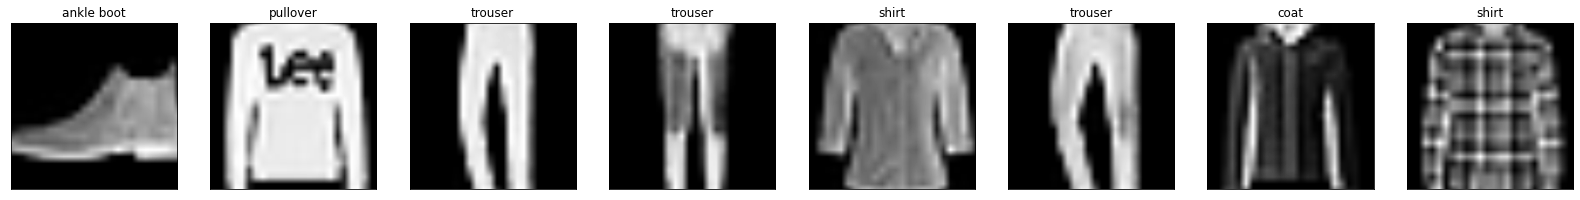

In [34]:
test(model, test_dataloader, device)